# Simple Forecasting

## Our Focus problem are :
- Regressiong Problem ( trying to get forecast exactly close price or return next day )
- Binary classification problem ( price will go up [1;0] or down [0;1] )


In [66]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

%matplotlib inline  

plt.rcParams["figure.figsize"] = [16,9]

## Prepare the data
We want to predict t+1 value based on N previous days information (historical financial data).
Example : having close prices from past 30 days on the market we want to predict, what price willl be tomorrow, on the 31th day.
we will use 90% as training set and 10% as testing for model evaluation.

In [67]:
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.predictions = []
        self.i = 0
        self.save_every = 5000

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.i += 1        
        if self.i % self.save_every == 0:        
            pred = model.predict(X_train)
            self.predictions.append(pred)
            
def load_close():
    f = open('stockdatas/SPY.csv', 'r').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            close_price = float(line.split(',')[4])
            raw_data.append(close_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue
    return raw_data, raw_dates

def load_returns():
    f = open('stockdatas/SPY.csv', 'r').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.split(',')[1])
            close_price = float(line.split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data[::-1], raw_dates[::-1]

def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

# Regression problem - Multi Layer Perceptron (MLP)

It will be just 2 hidden layer perceptron. between 2 layers we add one dropout layer to prevent overfitting.

Dense(1), Activation and mse in compile section is important thing. We want one output that can be any range (we predict real value) and our loss function is defined as mean squared error (MSE).

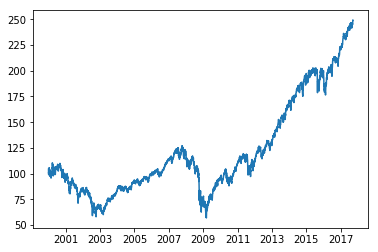

In [6]:
timeseries, dates = load_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [9]:
TRAIN_SIZE = 20 # 20 days close prices
TARGET_TIME = 1 # predict the 21th day
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [29]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, verbose=1)
print("\nScore :",score)

Train on 3591 samples, validate on 399 samples
Epoch 1/5
3591/3591 [==============================] - 0s - loss: 1326.7961 - val_loss: 173.1033
Epoch 2/5
3591/3591 [==============================] - 0s - loss: 133.2259 - val_loss: 8.4058
Epoch 3/5
3591/3591 [==============================] - 0s - loss: 83.4461 - val_loss: 24.4580
Epoch 4/5
3591/3591 [==============================] - 0s - loss: 64.3427 - val_loss: 8.9721
Epoch 5/5
 32/444 [=>............................] - ETA: 0s
Score : 208.511168059


Mean Squared Error :  232763.0


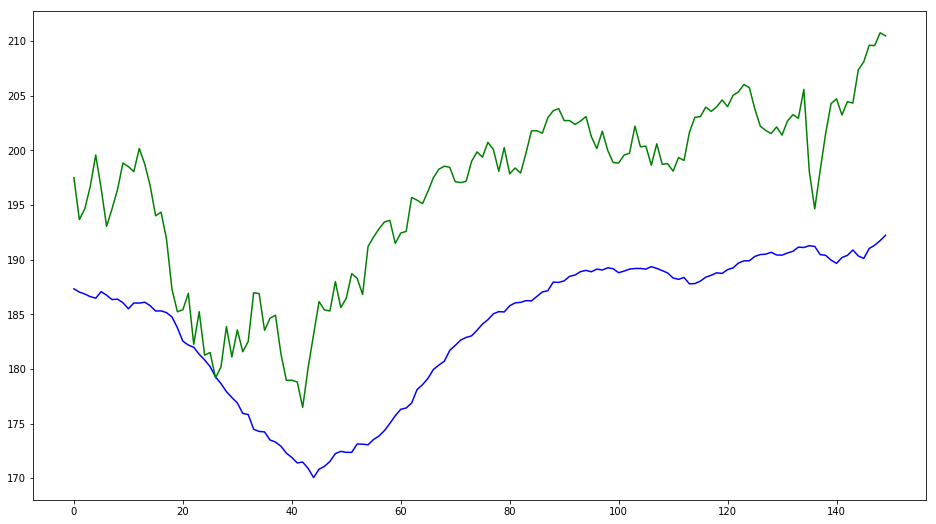

In [30]:

params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)
    

mse = mean_squared_error(predicted, new_predicted)
print ("Mean Squared Error : ",mse)

try:
    #plt.plot(Y_test[:150], color='black') # BLACK - trained RESULT
    plt.plot(predicted[:150], color='blue') # BLUE - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    #plt.plot(new_predicted[:150], color='red') # RED - restored PREDICTION
    plt.show()
except Exception as e:
    print (str(e))

# Regression problem - RNN

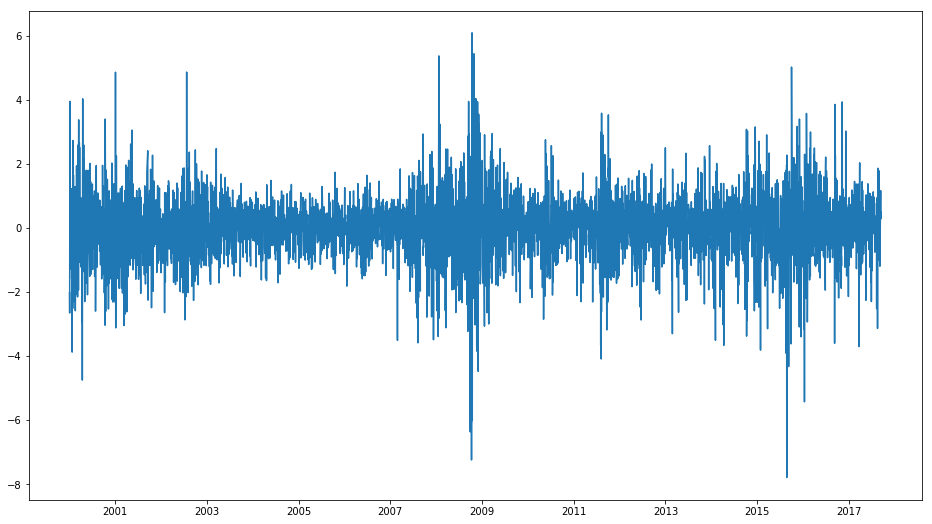

In [33]:
timeseries, dates = load_returns()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [46]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1
HIDDEN_RNN = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)

print (len(X), len(Y))

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

4434 4434


In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

model = Sequential()

model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=True))
model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=False))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])

/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=1, input_shape=(None, 1))`
  
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=1, input_shape=(None, 1))`
  import sys


In [51]:
model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)


score = model.evaluate(X_test, Y_test, batch_size=128)
print ("\nScore :",score)

Train on 3591 samples, validate on 399 samples
Epoch 1/5
3591/3591 [==============================] - 0s - loss: 0.2491 - acc: 0.5299 - val_loss: 0.2478 - val_acc: 0.5514
Epoch 2/5
3591/3591 [==============================] - 0s - loss: 0.2491 - acc: 0.5299 - val_loss: 0.2478 - val_acc: 0.5514
Epoch 3/5
3591/3591 [==============================] - 0s - loss: 0.2491 - acc: 0.5299 - val_loss: 0.2477 - val_acc: 0.5514
Epoch 4/5
3591/3591 [==============================] - 0s - loss: 0.2491 - acc: 0.5299 - val_loss: 0.2477 - val_acc: 0.5514
Epoch 5/5
128/444 [=======>......................] - ETA: 0s
Score : [0.25402992131473784, 0.44819819658726184]


In [53]:
timeseries, dates = load_returns()
X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Y_train, Y_test = np.array([y.argmax() for y in Y_train]), np.array([y.argmax() for y in Y_test])


from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics, svm
from sklearn import linear_model

print ('Training...')

#classifier = RandomForestClassifier(n_estimators = 100,
#                               n_jobs=4,
#                               verbose=1)

#classifier = linear_model.LogisticRegression(C=1e-5)

classifier = svm.SVC()
classifier.fit(X_train, Y_train)

print ('Prediction...')
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(Y_test, predicted)))

Training...
Prediction...
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.45      0.69      0.54       199
          1       0.55      0.31      0.40       245

avg / total       0.51      0.48      0.46       444




# Classification problem - MLP

In [54]:
TRAIN_SIZE = 20 # 20 days close prices
TARGET_TIME = 1 # predict the 21th day
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [55]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
			  loss='binary_crossentropy', 
			  metrics=['accuracy'])

In [59]:
history = model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)

Train on 3591 samples, validate on 399 samples
Epoch 1/5
3591/3591 [==============================] - 0s - loss: 0.6512 - acc: 0.6190 - val_loss: 0.7222 - val_acc: 0.4762
Epoch 2/5
3591/3591 [==============================] - 0s - loss: 0.6487 - acc: 0.6271 - val_loss: 0.7247 - val_acc: 0.5063
Epoch 3/5
3591/3591 [==============================] - 0s - loss: 0.6391 - acc: 0.6330 - val_loss: 0.7289 - val_acc: 0.5038
Epoch 4/5
3591/3591 [==============================] - 0s - loss: 0.6344 - acc: 0.6422 - val_loss: 0.7375 - val_acc: 0.4987
Epoch 5/5
3591/3591 [==============================] - 0s - loss: 0.6238 - acc: 0.6586 - val_loss: 0.7351 - val_acc: 0.4687


In [60]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("\nModel Accuracy: %.2f%%" % (scores[1]*100))

288/444 [==================>...........] - ETA: 0s
Model Accuracy: 52.70%


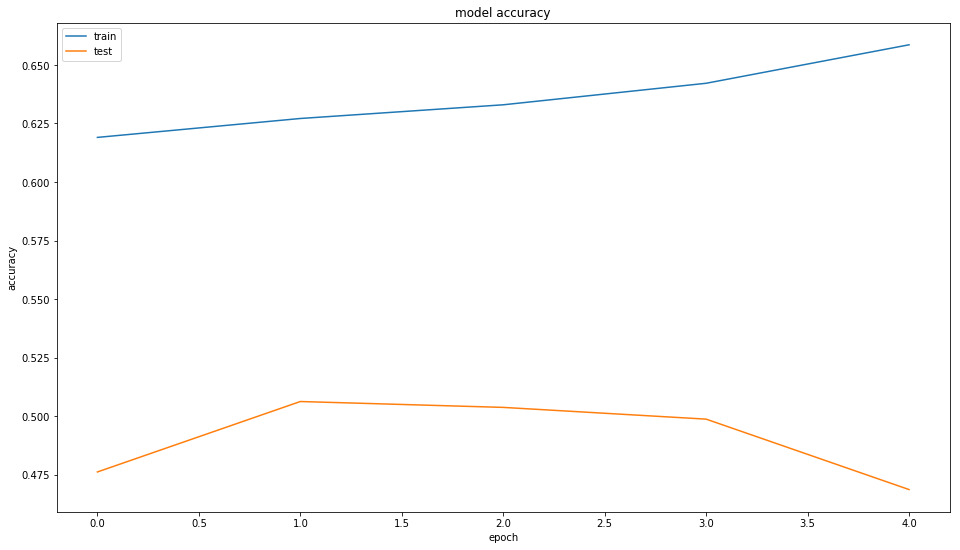

In [61]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Classification problem - CNN

In [68]:
model = Sequential()
model.add(Convolution1D(input_shape = (TRAIN_SIZE, EMB_SIZE), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Convolution1D(input_shape = (TRAIN_SIZE, EMB_SIZE), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(250))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

history = TrainingHistory()

model.compile(optimizer='adam', 
			  loss='binary_crossentropy', 
			  metrics=['accuracy'])

/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=2, padding="valid", activation="relu", filters=64, strides=1, input_shape=(20, 1))`
  import sys
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=2, padding="valid", activation="relu", filters=64, strides=1, input_shape=(20, 1))`
  from ipykernel import kernelapp as app
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  app.launch_new_instance()


In [72]:
model.fit(X_train, Y_train, batch_size=128, epochs=5,
          validation_data=(X_test, Y_test), verbose=2)
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score)

ValueError: Error when checking input: expected conv1d_9_input to have 3 dimensions, but got array with shape (3990, 20)